In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [3]:
# Pobranie bieżącego katalogu
current_dir = os.getcwd()

#zestaw trenowanie i walidacja
data_dir = os.path.join(current_dir, 'images')

#zestaw testowanie
test_dir = os.path.join(current_dir, 'test_images')

# Liczenie plików .jpg w katalogu data_dir
image_count = len(glob.glob(data_dir + '/*/*.jpg'))
print(image_count)

image_count = len(glob.glob(test_dir + '/*/*.jpg'))
print(image_count)

57147
13409


In [4]:
#podgląd zdjęć
AnimeFaces = glob.glob(os.path.join(data_dir, 'AnimeFace*'))
img_path = AnimeFaces[0]

# Sprawdź, czy img_path jest katalogiem
if os.path.isdir(img_path):
    # Jeśli img_path jest katalogiem, wybierz pierwszy plik obrazu z tego katalogu
    img_files = glob.glob(os.path.join(img_path, '*.jpg'))
    if img_files:
        img_path = img_files[0]
    else:
        print("Brak plików obrazów w katalogu", img_path)
        exit()

img = Image.open(img_path)
img.show()

In [5]:
#rozmiar zdjęć i paczek
batch_size = 32
img_height = 180
img_width = 180

In [6]:
#dane treningowe 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 57375 files belonging to 2 classes.
Using 45900 files for training.


In [7]:
#Dane walidacyjne 
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 57375 files belonging to 2 classes.
Using 11475 files for validation.


In [8]:
#Dane testowe 
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13409 files belonging to 2 classes.


In [9]:
#nazwy rozpoznawanych klas
class_names = train_ds.class_names
print(class_names)

['AnimeFace', 'NonAnimeFace']


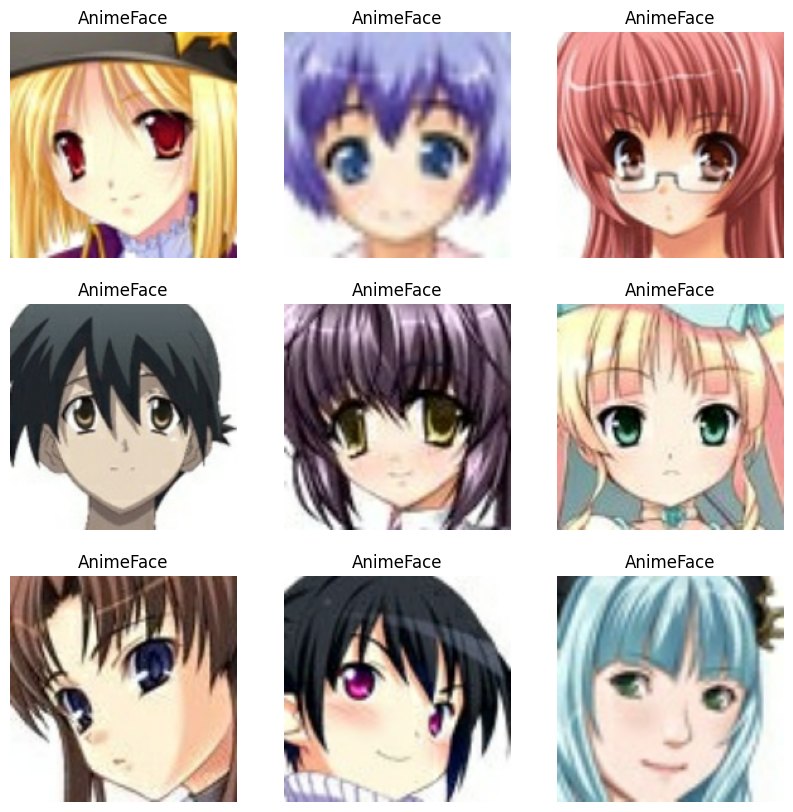

In [10]:
#pierwsze zdjęcia ze zbioru treningowego 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [25]:
#Konfikuracja danych pod kątem wydajności 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [168]:
num_classes = len(class_names)

# Normalizacja pikseli do wartości z zakresu [0, 1]
# Wejściowa forma obrazu: (img_height, img_width, 3)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  # Pierwsza warstwa konwolucyjna z 16 filtrami o rozmiarze 3x3,
  # funkcja aktywacji ReLU, zachowanie rozmiaru obrazu
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  
  # Warstwa MaxPooling zmniejszająca wymiary obrazu o połowę
  layers.MaxPooling2D(),
  
  # Druga warstwa konwolucyjna z 32 filtrami o rozmiarze 3x3,
  # funkcja aktywacji ReLU, zachowanie rozmiaru obrazu
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  
  # Druga warstwa MaxPooling zmniejszająca wymiary obrazu o połowę
  layers.MaxPooling2D(),
  
  # Trzecia warstwa konwolucyjna z 64 filtrami o rozmiarze 3x3,
  # funkcja aktywacji ReLU, zachowanie rozmiaru obrazu
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  # Trzecia warstwa MaxPooling zmniejszająca wymiary obrazu o połowę
  layers.MaxPooling2D(),
  
  # Warstwa spłaszczająca dane do postaci jednowymiarowej
  layers.Flatten(),
  
  # Warstwa w pełni połączona z 128 neuronami, funkcja aktywacji ReLU
  layers.Dense(128, activation='relu'),
  
  # Warstwa w pełni połączona z liczbą klas jako wyjście modelu
  # (funkcja aktywacji softmax, ponieważ mamy do czynienia z wieloklasowym problemem klasyfikacji)
  layers.Dense(num_classes, activation='softmax')
])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [169]:
#kompilacja modelu
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [170]:
#podsumowanie modelu
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
#trenowanie modelu
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 80s 55ms/step - accuracy: 0.9867 - loss: 0.0465 - val_accuracy: 0.9984 - val_loss: 0.0040
Epoch 2/3
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.9975 - loss: 0.0078 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 3/3
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.9990 - loss: 0.0044 - val_accuracy: 0.9993 - val_loss: 0.0016


In [96]:
#testownie na danych testowych
test_loss,test_accuracy = model.evaluate(test_ds)

420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9871 - loss: 0.0371


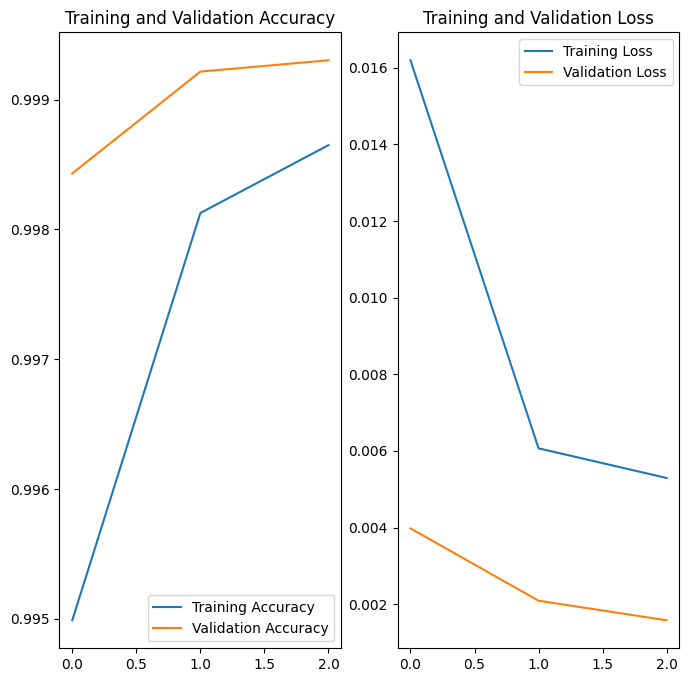

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [146]:
# Wczytaj obraz przy użyciu OpenCV
image = cv2.imread("anime.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV wczytuje obraz w formacie BGR, dlatego konieczna jest konwersja na RGB

# Dostosuj rozmiar obrazu do oczekiwanego przez model
image = cv2.resize(image, (180, 180))

# Przewidź klasę obrazu
pred = model.predict(image.reshape(1, 180, 180, 3), batch_size=1)

# Konwertuj wyniki na wartości prawdopodobieństwa za pomocą softmax
probs = tf.nn.softmax(pred)

# Wyświetl wyniki
predicted_class = np.argmax(probs)
predicted_class_name = class_names[predicted_class]
confidence = np.max(probs) * 100  # Prawdopodobieństwo w procentach
print("Predicted class:", predicted_class_name)
print("Confidence:", confidence, "%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted class: AnimeFace
Confidence: 100.0 %


In [147]:
# Zapisanie modelu
model.save('face_classifier_model.h5')

In [217]:
# Funkcja dostosowująca kształt etykiet
def adjust_labels(loss_function, labels):
    loss_function_name = loss_function.__class__.__name__
    if loss_function_name == 'SparseCategoricalCrossentropy':
        return labels
    elif loss_function_name in ['CategoricalCrossentropy', 'BinaryCrossentropy']:
        return tf.keras.utils.to_categorical(labels, num_classes)
    else:
        raise ValueError("Unsupported loss function")

In [218]:
# Kompilacja modelu
def compile_and_train(optimizer, loss):
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    history = model.fit(
        train_ds.map(lambda x, y: (x, adjust_labels(loss, y))),
        validation_data=val_ds.map(lambda x, y: (x, adjust_labels(loss, y))),
        epochs=epochs,
        verbose=0  # Set verbose to 0 to suppress training output
    )
    
    return history

420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9544 - loss: 0.1713
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9878 - loss: 0.0545
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9826 - loss: 0.1026
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9806 - loss: 0.3084
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9814 - loss: 0.3256
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9841 - loss: 0.1931
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9841 - loss: 0.3799
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9843 - loss: 0.3751
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9844 - loss: 0.1932


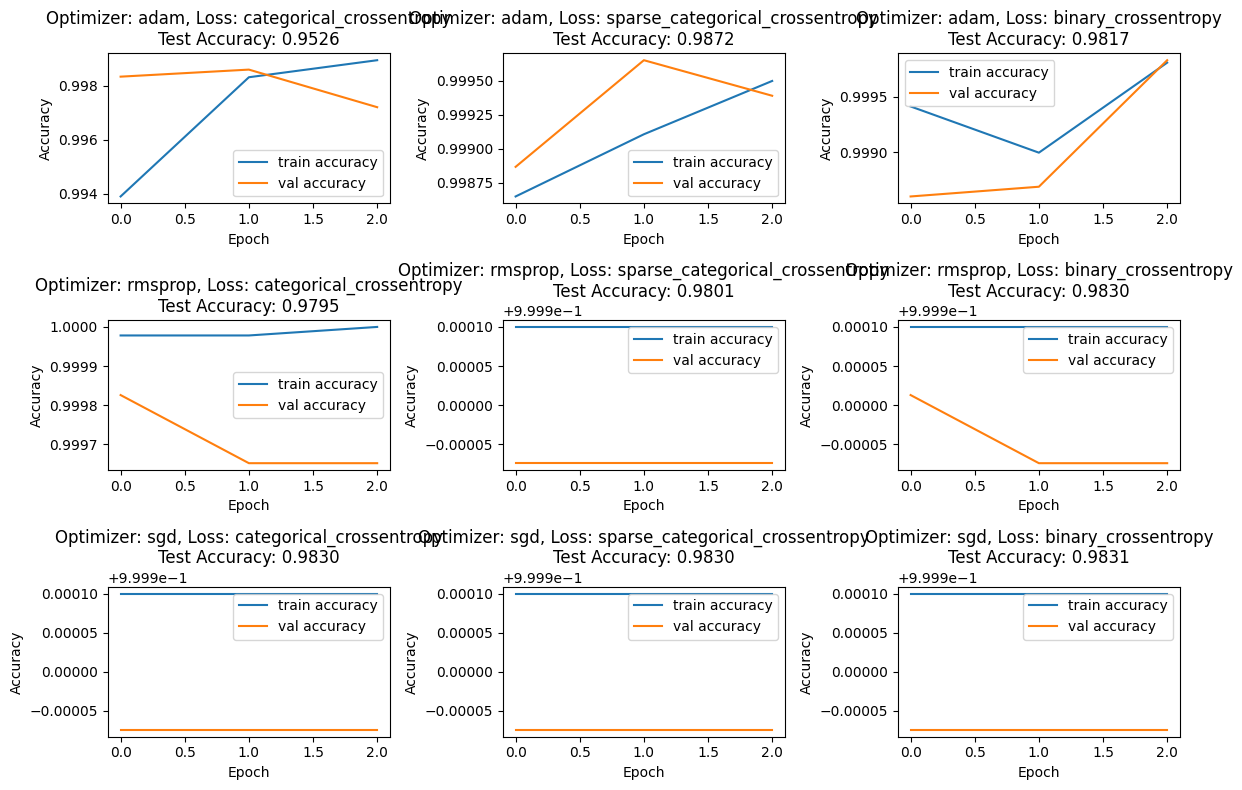

In [219]:
#testowanie innych funkcji optymalizacji i straty dla tego samego modelu
# Lista różnych funkcji optymalizacji do przetestowania
optimizers = ['adam', 'rmsprop', 'sgd']

# Lista różnych funkcji strat do przetestowania
loss_functions = [tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  tf.keras.losses.BinaryCrossentropy(from_logits=False)]

#zmienna na wyniki
results = []

#trenowanie mmodelu
for optimizer in optimizers:
    for loss_function in loss_functions:
        history = compile_and_train(optimizer, loss_function)
        test_loss, test_accuracy = model.evaluate(test_ds.map(lambda x, y: (x, adjust_labels(loss_function, y))))
        results.append((optimizer, loss_function, test_loss, test_accuracy, history))


# Wykres porównujący wyniki
plt.figure(figsize=(12, 8))

for i, result in enumerate(results, 1):
    optimizer, loss_function, test_loss, test_accuracy, history = result
    plt.subplot(3, 3, i)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Optimizer: {optimizer}, Loss: {loss_function.name}\nTest Accuracy: {test_accuracy:.4f}')
    plt.legend()

plt.tight_layout()
plt.show()